# Translation using a Transformer in Tensorflow

Tutorial link [here](https://www.tensorflow.org/text/tutorials/transformer).

Note we also have to perform 
```
conda install -c nvidia cuda-nvcc
```

in order to get tensorflow to properly use cuda in addition to steps mentioned in the TF guide

In [7]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
# tensorflow_text seems to be required to load the tokenizers
import tensorflow_text

import matplotlib.pyplot as plt


In [8]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Loading the Dataset and Tokenizer

In [9]:
# Note that by default data is saved in ~/tensorflow_datasets

examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en',
                               with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples["train"], examples["validation"]

In [10]:
for pt_examples, en_examples in train_examples.batch(3).take(1):
    for pt, en in zip(pt_examples.numpy(), en_examples.numpy()):
        print("Example in Portugese:")
        print(pt.decode("utf-8"))
        print("Example in English:")
        print(en.decode("utf-8"))
        print("===========================")
        

Example in Portugese:
e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
Example in English:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
Example in Portugese:
mas e se estes fatores fossem ativos ?
Example in English:
but what if it were active ?
Example in Portugese:
mas eles não tinham a curiosidade de me testar .
Example in English:
but they did n't test for curiosity .


2023-05-23 20:50:26.459796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-05-23 20:50:26.460590: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]
2023-05-23 20:50:26.492956: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline si

## Setting up the Tokenizer

In [11]:
tokenizer_name = "ted_hrlr_translate_pt_en_converter"
tf.keras.utils.get_file(f"{tokenizer_name}.zip", 
                        f'https://storage.googleapis.com/download.tensorflow.org/models/{tokenizer_name}.zip',
                        cache_dir='.', cache_subdir='', extract=True)


'./ted_hrlr_translate_pt_en_converter.zip'

In [12]:
tokenizers = tf.saved_model.load(tokenizer_name)

In [13]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

In [14]:
[item for item in dir(tokenizers.pt) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

In [15]:
tokenized_en = tokenizers.en.tokenize(en_examples)
for i,en in enumerate(en_examples.numpy()):
    print(en.decode("utf-8"))
    print(tokenized_en.to_list()[i])


and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
but what if it were active ?
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
but they did n't test for curiosity .
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]


In [16]:
round_trip_en = tokenizers.en.detokenize(tokenized_en)

2023-05-23 20:50:30.442240: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'tokenized' with dtype int64 and shape [?]
	 [[{{node tokenized}}]]
2023-05-23 20:50:30.442365: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'tokenized_1' with dtype int64 and shape [4]
	 [[{{node tokenized_1}}]]


In [17]:
round_trip_en.numpy()

array([b'and when you improve searchability , you actually take away the one advantage of print , which is serendipity .',
       b'but what if it were active ?',
       b"but they did n ' t test for curiosity ."], dtype=object)

In [18]:
# The lookup method gives the subword pieces

tokenizers.en.lookup(tokenized_en).numpy()

array([array([b'[START]', b'and', b'when', b'you', b'improve', b'search',
              b'##ability', b',', b'you', b'actually', b'take', b'away', b'the',
              b'one', b'advantage', b'of', b'print', b',', b'which', b'is', b's',
              b'##ere', b'##nd', b'##ip', b'##ity', b'.', b'[END]'], dtype=object),
       array([b'[START]', b'but', b'what', b'if', b'it', b'were', b'active',
              b'?', b'[END]'], dtype=object)                                ,
       array([b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test',
              b'for', b'curiosity', b'.', b'[END]'], dtype=object)           ],
      dtype=object)

## Setting up batchedata pipeline

The following function takes batches of text as input, and converts them to a format suitable for training.

1. It tokenizes them into ragged batches.
2. It trims each to be no longer than MAX_TOKENS.
3. It splits the target (English) tokens into inputs and labels. These are shifted by one step so that at each input location the label is the id of the next token.
4. It converts the RaggedTensors to padded dense Tensors.
5. It returns an (inputs, labels) pair.

In [19]:
MAX_TOKENS=128
BUFFER_SIZE = 20000
BATCH_SIZE=64


def prepare_batch(pt, en):
    pt = tokenizers.pt.tokenize(pt)
    pt = pt[:, :MAX_TOKENS]
    pt = pt.to_tensor()

    en = tokenizers.en.tokenize(en)
    en = en[:, :(MAX_TOKENS+1)]
    en_inputs = en[:, :-1].to_tensor()
    en_labels = en [:, 1:].to_tensor()
    return (pt,en_inputs), en_labels



The function below converts a dataset of text examples into data of batches for training.

1. It tokenizes the text, and filters out the sequences that are too long. (The batch/unbatch is included because the tokenizer is much more efficient on large batches).
2. The cache method ensures that that work is only executed once.
3. Then shuffle and, dense_to_ragged_batch randomize the order and assemble batches of examples.
4. Finally prefetch runs the dataset in parallel with the model to ensure that data is available when needed. See Better performance with the tf.data for details.

In [20]:

def make_batches(ds):
    return(
        ds.shuffle(BUFFER_SIZE)
        .batch(BATCH_SIZE)
        .map(prepare_batch, tf.data.AUTOTUNE)
        .prefetch(buffer_size = tf.data.AUTOTUNE)
    )

In [21]:
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

In [22]:
for (pt,en), en_labels in train_batches.take(1):
    break


2023-05-23 20:50:32.349041: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_32' with dtype int64
	 [[{{node Placeholder/_32}}]]
2023-05-23 20:50:32.349542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]
2023-05-23 20:50:33.487105: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `da

In [23]:
print("Shape of PT Batch: ",pt.shape)
print("Shape of EN Batch: ",en.shape)
print("Shape of Labels Batch: ",en_labels.shape)

Shape of PT Batch:  (64, 128)
Shape of EN Batch:  (64, 90)
Shape of Labels Batch:  (64, 90)


In [24]:
en[0,:10]


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([   2,   10,  177,   11,   78,    9,  142,  162, 6715,  118])>

In [25]:
en_labels[0,:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([  10,  177,   11,   78,    9,  142,  162, 6715,  118,  108])>

## Positional Encoding

In [26]:
def positional_encoding(length, depth, use_original=False):
    """_summary_

    Args:
        length (_type_): the number of tokens in the array
        depth (_type_): the depth of the encoding
        use_original (bool, optional): Whether to use original formula or the new one in the tutorial. Defaults to False.

    Returns:
        _type_: _description_
    """
    depth = depth/2

    positions = np.arange(length)[:,np.newaxis]
    depths = np.arange(depth)[np.newaxis,:]/depth
    angle_rates = 1/(10000**depths)
    angle_rads = positions*angle_rates
    if use_original:
        pos_encoding = np.empty([length, int(depth*2)], dtype = np.float32)
        pos_encoding[:,0::2]=np.sin(angle_rads)
        pos_encoding[:,1::2]=np.cos(angle_rads)
    else:
        pos_encoding = np.concatenate(
          [np.sin(angle_rads), np.cos(angle_rads)],
          axis=-1) 
    return tf.cast(pos_encoding, dtype=tf.float32)

(2048, 512)


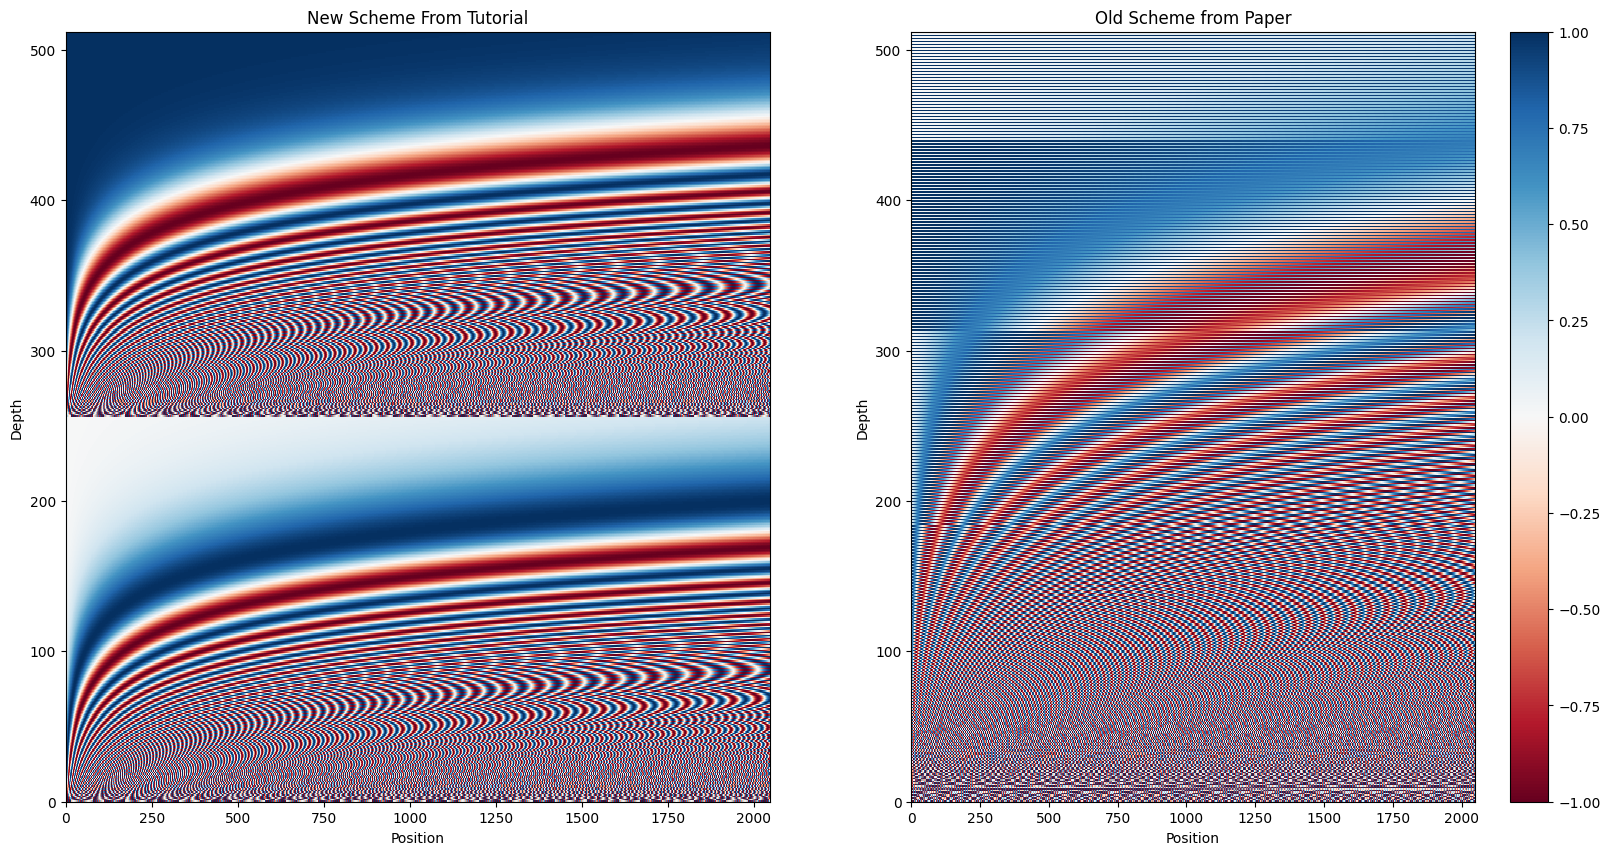

In [27]:
pos_encoding = positional_encoding(length=2048, depth=512)
pos_encoding_old = positional_encoding(length=2048, depth=512, use_original=True)
# Check the shape.
print(pos_encoding.shape)

# Plot the dimensions.

f, (ax1,ax2)=plt.subplots(1,2, figsize=(20,10))

ax1.set_title("New Scheme From Tutorial")
ax1.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
ax1.set_ylabel('Depth')
ax1.set_xlabel('Position')
ax2.set_title("Old Scheme from Paper")
pcm = ax2.pcolormesh(pos_encoding_old.numpy().T, cmap='RdBu')
ax2.set_ylabel('Depth')
ax2.set_xlabel('Position')
f.colorbar(pcm, ax=ax2)
plt.show()

## Creating  Embedding Layer

In [28]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size,d_model, mask_zero=True)
        self.pos_encoding = positional_encoding(length=2048, depth = d_model)

    def compute_mask(self, *args, **kwargs):
        return self. embedding.compute_mask(*args, **kwargs)
    
    def call(self, x):
        length = tf.shape(x)[1] # 0th dim is batch dim
        x = self.embedding(x)
        ## We are rescaling the embeddings by sqrt(d)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        ## Here we add a batch dim to positional enc and crop to length of batch
        x = x+ self.pos_encoding[tf.newaxis,:length,:]
        return x 


In [29]:
embed_pt_layer = PositionalEmbedding(vocab_size= tokenizers.pt.get_vocab_size(), d_model=512)
embed_en_layer= PositionalEmbedding(vocab_size= tokenizers.en.get_vocab_size(), d_model=512)

# Trying it out on the take(1) data
pt_emb = embed_pt_layer(pt)
en_emb = embed_en_layer(en)



In [30]:
pt_emb

<tf.Tensor: shape=(64, 128, 512), dtype=float32, numpy=
array([[[-0.356773  , -0.77581596, -0.6460455 , ...,  0.3992756 ,
          1.6724001 ,  0.97584563],
        [ 1.38866   , -0.07433981,  0.8743033 , ...,  1.1723932 ,
          0.24934155,  1.2347198 ],
        [ 1.9810598 ,  0.24584895,  0.08277231, ...,  0.32714856,
         -0.12672031,  1.0366167 ],
        ...,
        [-1.6991878 , -0.11451656,  0.5741075 , ...,  1.1887156 ,
          1.1598754 ,  1.246782  ],
        [-0.7531564 , -0.21978277, -0.19191182, ...,  1.1887139 ,
          1.159874  ,  1.2467806 ],
        [-0.1105172 , -1.0372564 , -0.27467513, ...,  1.1887124 ,
          1.1598725 ,  1.2467792 ]],

       [[-0.356773  , -0.77581596, -0.6460455 , ...,  0.3992756 ,
          1.6724001 ,  0.97584563],
        [ 0.18928319,  0.3699945 ,  0.9204695 , ...,  0.61572325,
          1.6883254 ,  1.5673404 ],
        [ 0.25710964,  0.484553  ,  1.0766522 , ...,  0.61572325,
          1.6883254 ,  1.5673404 ],
        ...

In [31]:
en_emb

<tf.Tensor: shape=(64, 90, 512), dtype=float32, numpy=
array([[[-0.08540528, -0.43871376,  0.44832993, ...,  0.6244124 ,
          0.58719313,  1.5050511 ],
        [-0.02974737,  0.18972385,  0.8748082 , ..., -0.12312222,
          1.2315476 ,  1.936449  ],
        [ 0.13640887,  1.5002112 ,  1.56416   , ...,  0.36387336,
         -0.06474137,  1.5674596 ],
        ...,
        [-1.090866  ,  0.16280597, -0.51834035, ...,  1.1702487 ,
          0.24123079,  0.65244865],
        [-0.23364988, -0.68609774,  0.34969136, ...,  1.1702477 ,
          0.24122977,  0.6524477 ],
        [ 0.5910212 , -1.4771941 ,  1.0507032 , ...,  1.1702465 ,
          0.24122876,  0.65244675]],

       [[-0.08540528, -0.43871376,  0.44832993, ...,  0.6244124 ,
          0.58719313,  1.5050511 ],
        [ 1.8912576 ,  1.1978045 , -0.06168741, ...,  1.0464891 ,
          1.1990958 ,  0.24257869],
        [ 0.31459987,  1.9759766 ,  0.8575748 , ...,  1.1765779 ,
          1.6058246 ,  0.4815687 ],
        ...,

In [32]:
en_emb._keras_mask

<tf.Tensor: shape=(64, 90), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

In [33]:
en[0]

<tf.Tensor: shape=(90,), dtype=int64, numpy=
array([   2,   10,  177,   11,   78,    9,  142,  162, 6715,  118,  108,
       1252,   15,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0])>

In [34]:
en_emb._keras_mask[0]

<tf.Tensor: shape=(90,), dtype=bool, numpy=
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])>

## Paying attention

In [35]:


class BaseAttention(tf.keras.layers.Layer):
  """Base Class that just defines the Multiheaded Attention, Layernorm and Add layers

  Args:
      tf (_type_): Args to the MHA Layer
  """
  def __init__(self, **kwargs):
      super().__init__()
      self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
      self.layernorm = tf.keras.layers.LayerNormalization()
      self.add = tf.keras.layers.Add() # + sign does not respect masking, have to use Add

class CrossAttention(BaseAttention):
  """Cross Attention layer with call function. See how context is being passed as key/value
  """
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x
  

class GlobalSelfAttention(BaseAttention):
  """ Self Attention layer with call function. No masking is enforced
   To be used in Encoder
  """
  def call(self, x):
      attn_output = self.mha(query=x, key=x, value=x)
      x = self.add([x, attn_output])
      x = self.layernorm(x)
      return x
  
class CausalSelfAttention(BaseAttention):
  """ Self Attention layer with call function. Masking is enforced
   To be used in Decoder
  """
  def call(self,x):
     attn_output = self.mha(query=x, key=x, value=x, use_causal_mask=True)
     x = self.add([x, attn_output])
     x = self.layernorm(x)
     return x
    



In [36]:

sample_ca = CrossAttention(num_heads=2, key_dim=512)

print(pt_emb.shape)
print(en_emb.shape)
print(sample_ca(en_emb, pt_emb).shape)



(64, 128, 512)
(64, 90, 512)
(64, 90, 512)


2023-05-23 20:50:36.290025: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


In [37]:
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)

print(pt_emb.shape)
print(sample_gsa(pt_emb).shape)
    


(64, 128, 512)
(64, 128, 512)


In [38]:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)

print(en_emb.shape)
print(sample_csa(en_emb).shape)

(64, 90, 512)
(64, 90, 512)


## Feed Forward Network

In [39]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential(
            [tf.keras.layers.Dense(dff, activation="relu"),
             tf.keras.layers.Dense(d_model), # Note the absense of activation. We don't want this rectified to 0
             tf.keras.layers.Dropout(dropout_rate)   
            ]
        )
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        seq_x = self.seq(x)
        x = self.add([x,seq_x])
        x = self.layer_norm(x)
        return x 
    



In [40]:
sample_ffn = FeedForward(512, 2048)

print(en_emb.shape)
print(sample_ffn(en_emb).shape)

(64, 90, 512)
(64, 90, 512)


## Encoder Layer

In [41]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()
        self.self_attention = GlobalSelfAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout_rate) # All args being passed to mha
        self.ffn = FeedForward(d_model=d_model, dff=dff)

    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x
    


In [42]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

print(pt_emb.shape)
print(sample_encoder_layer(pt_emb).shape)

(64, 128, 512)
(64, 128, 512)


## Encoder Block

In [43]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self,*, num_layers,d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
        super().__init__()
        self.d_model= d_model
        self.num_layers = num_layers
        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,d_model=d_model)
        self.enc_layers= [EncoderLayer(d_model=d_model, num_heads=num_heads,dff=dff, dropout_rate=dropout_rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self,x):
        x= self.pos_embedding(x)
        x = self.dropout(x)
        for i in range(self.num_layers):
            x = self.enc_layers[i](x)
        return x
    

        

In [44]:
sample_encoder = Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8500)

sample_encoder_output = sample_encoder(pt, training=False)

# Print the shape.
print(pt.shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`

(64, 128)
(64, 128, 512)


## The Decoder Layer

In [45]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
        super(DecoderLayer, self).__init__()
        self.casual_self_attention = CausalSelfAttention(num_heads = num_heads, key_dim= d_model,dropout=dropout_rate)
        self.cross_attention = CrossAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)
        self.ffn = FeedForward(d_model=d_model, dff=dff)
    
    def call(self, x, context):
        x = self.casual_self_attention(x)
        x = self.cross_attention(x=x, context=context)
        self.last_attn_scores = self.cross_attention.last_attn_scores
        x = self.ffn(x)
        return x


In [46]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_decoder_layer_output = sample_decoder_layer(
    x=en_emb, context=pt_emb)

print(en_emb.shape)
print(pt_emb.shape)
print(sample_decoder_layer_output.shape)  # `(batch_size, seq_len, d_model)`

(64, 90, 512)
(64, 128, 512)
(64, 90, 512)


## Decoder

In [47]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self,*, num_layers,d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
        super().__init__()
        self.d_model= d_model
        self.num_layers = num_layers
        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,d_model=d_model)
        self.dec_layers= [DecoderLayer(d_model=d_model, num_heads=num_heads,dff=dff, dropout_rate=dropout_rate) for _ in range(num_layers)]
        self.last_attn_scores= None
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self,x, context):
        x= self.pos_embedding(x)
        x = self.dropout(x)
        for i in range(self.num_layers):
            x = self.dec_layers[i](x, context)
        self.last_attn_scores = self.dec_layers[-1].last_attn_scores
        return x
    

In [48]:
sample_decoder = Decoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8000)

output = sample_decoder(
    x=en,
    context=pt_emb)

# Print the shapes.
print(en.shape)
print(pt_emb.shape)
print(output.shape)

(64, 90)
(64, 128, 512)
(64, 90, 512)


In [49]:
sample_decoder.last_attn_scores.shape # (batch, heads, target_seq, input_seq)

TensorShape([64, 8, 90, 128])

# The Transformer

In [50]:
class Transformer(tf.keras.Model):
    def __init__(self,*, num_layers,d_model, num_heads, dff, input_vocab_size, target_vocab_size, dropout_rate=0.1):
        super().__init__()
        self.encoder = Encoder(num_layers=num_layers,
                               num_heads=num_heads,
                               d_model=d_model,
                               dff=dff,
                               vocab_size=input_vocab_size,
                               dropout_rate=dropout_rate)
        self.decoder = Decoder(num_layers=num_layers,
                               num_heads=num_heads,
                               d_model=d_model,
                               dff=dff,
                               vocab_size=target_vocab_size,
                               dropout_rate=dropout_rate)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inputs):
        context, x = inputs
        context = self.encoder(context)
        x = self.decoder(x, context)
        logits = self.final_layer(x)
        try:
            # Drop the keras mask, so it doesn't scale the losses/metrics.
            del logits._keras_mask
        except AttributeError:
            pass
        return logits


## HyperParameters

In [51]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

In [52]:
transformer= Transformer(num_layers=num_layers, num_heads=num_heads, 
                         d_model=d_model, dff=dff,dropout_rate=dropout_rate,
                         input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
                        target_vocab_size=tokenizers.en.get_vocab_size().numpy())

In [53]:
output = transformer((pt,en))

In [54]:
print(en.shape)
print(pt.shape)
print(output.shape)

(64, 90)
(64, 128)
(64, 90, 7010)


In [55]:
attn_scores = transformer.decoder.last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)


(64, 8, 90, 128)


In [56]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  3632768   
                                                                 
 decoder_1 (Decoder)         multiple                  5647104   
                                                                 
 dense_38 (Dense)            multiple                  904290    
                                                                 
Total params: 10,184,162
Trainable params: 10,184,162
Non-trainable params: 0
_________________________________________________________________


## Training

### Adam with Custom LR

In [57]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [58]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

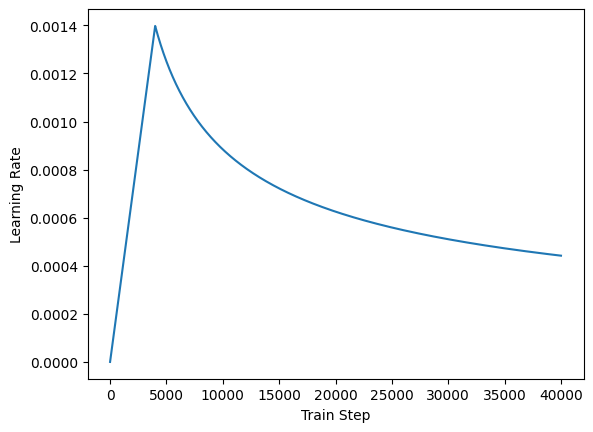

In [59]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

### Losses and Metrics

In [60]:
def masked_loss(label, pred):
    mask = label!=0
    loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss = loss_obj(label,pred)
    mask = tf.cast(mask, dtype = loss.dtype)
    loss*=mask

    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss

def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label==pred
    mask = label!=0
    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [61]:
transformer.compile(loss=masked_loss, optimizer= optimizer, metrics = [masked_accuracy])

transformer.fit(train_batches, epochs=1, validation_data=val_batches)

2023-05-23 20:50:45.095297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2023-05-23 20:50:45.095943: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_31' with dtype resource
	 [[{{node Placeholder/_31}}]]
2023-05-23 20:50:58.904551: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fc1f802f3e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-23 20:50:58.904594: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Com

810/810 [==============================] - ETA: 0s - loss: 6.6078 - masked_accuracy: 0.1411

2023-05-23 20:55:26.220487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_33' with dtype int64
	 [[{{node Placeholder/_33}}]]
2023-05-23 20:55:26.220986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


810/810 [==============================] - 285s 318ms/step - loss: 6.6078 - masked_accuracy: 0.1411 - val_loss: 5.0859 - val_masked_accuracy: 0.2381


In [62]:
transformer.fit(train_batches, epochs=19, validation_data=val_batches)

Epoch 1/19
810/810 [==============================] - 230s 284ms/step - loss: 4.6387 - masked_accuracy: 0.2867 - val_loss: 4.1850 - val_masked_accuracy: 0.3387
Epoch 2/19
810/810 [==============================] - 231s 285ms/step - loss: 3.9891 - masked_accuracy: 0.3508 - val_loss: 3.6466 - val_masked_accuracy: 0.3961
Epoch 3/19
810/810 [==============================] - 231s 285ms/step - loss: 3.5164 - masked_accuracy: 0.3982 - val_loss: 3.2447 - val_masked_accuracy: 0.4394
Epoch 4/19
810/810 [==============================] - 230s 283ms/step - loss: 3.1168 - masked_accuracy: 0.4420 - val_loss: 2.9410 - val_masked_accuracy: 0.4783
Epoch 5/19
810/810 [==============================] - 229s 283ms/step - loss: 2.7688 - masked_accuracy: 0.4859 - val_loss: 2.6271 - val_masked_accuracy: 0.5227
Epoch 6/19
810/810 [==============================] - 230s 283ms/step - loss: 2.4796 - masked_accuracy: 0.5255 - val_loss: 2.4753 - val_masked_accuracy: 0.5470
Epoch 7/19
810/810 [====================

## Inference 

In [90]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    # The input sentence is Portuguese, hence adding the `[START]` and `[END]` tokens.
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()

    encoder_input = sentence

    # As the output language is English, initialize the output with the
    # English `[START]` token.
    start_end = self.tokenizers.pt.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # The output shape is `(1, tokens)`.
    text = tokenizers.en.detokenize(output)[0]  # Shape: `()`.

    tokens = tokenizers.en.lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weights

In [91]:
translator = Translator(tokenizers, transformer)

def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

In [92]:
sentence = 'este é um problema que temos que resolver.'
ground_truth = 'this is a problem we have to solve .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é um problema que temos que resolver.
Prediction     : this is a problem that we have to solve .
Ground truth   : this is a problem we have to solve .


In [93]:
sentence = 'vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.'
ground_truth = "so i'll just share with you some stories very quickly of some magical things that have happened."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Prediction     : so i ' m going to be very quickly to share with you some stories of some magical things that happened .
Ground truth   : so i'll just share with you some stories very quickly of some magical things that have happened.


## Attention Plots

In [94]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

In [95]:
head = 0
# Shape: `(batch=1, num_heads, seq_len_q, seq_len_k)`.
attention_heads = tf.squeeze(attention_weights, 0)
attention = attention_heads[head]
attention.shape

TensorShape([23, 49])

In [96]:
## Input tokens

in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]
in_tokens

<tf.Tensor: shape=(20,), dtype=string, numpy=
array([b'[START]', b'vou', b'entao', b'muito', b'rapidamente',
       b'partilhar', b'convosco', b'algumas', b'historias', b'de',
       b'algumas', b'coisas', b'ma', b'##gica', b'##s', b'que',
       b'acontecera', b'##m', b'.', b'[END]'], dtype=object)>

In [97]:
## Translated Tokens
translated_tokens

<tf.Tensor: shape=(24,), dtype=string, numpy=
array([b'[START]', b'so', b'i', b"'", b'm', b'going', b'to', b'be',
       b'very', b'quickly', b'to', b'share', b'with', b'you', b'some',
       b'stories', b'of', b'some', b'magical', b'things', b'that',
       b'happened', b'.', b'[END]'], dtype=object)>

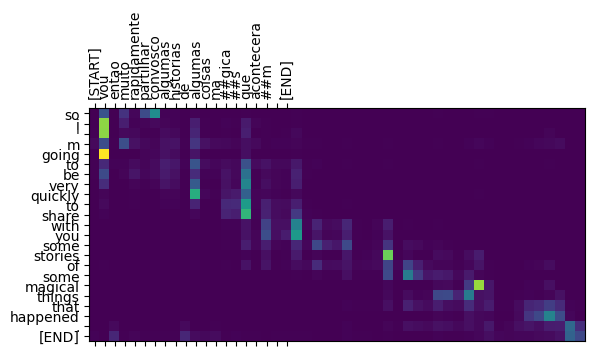

In [98]:
plot_attention_head(in_tokens, translated_tokens, attention)

Plotting all the heads together

In [99]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.pt.lookup(in_tokens)[0]

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()


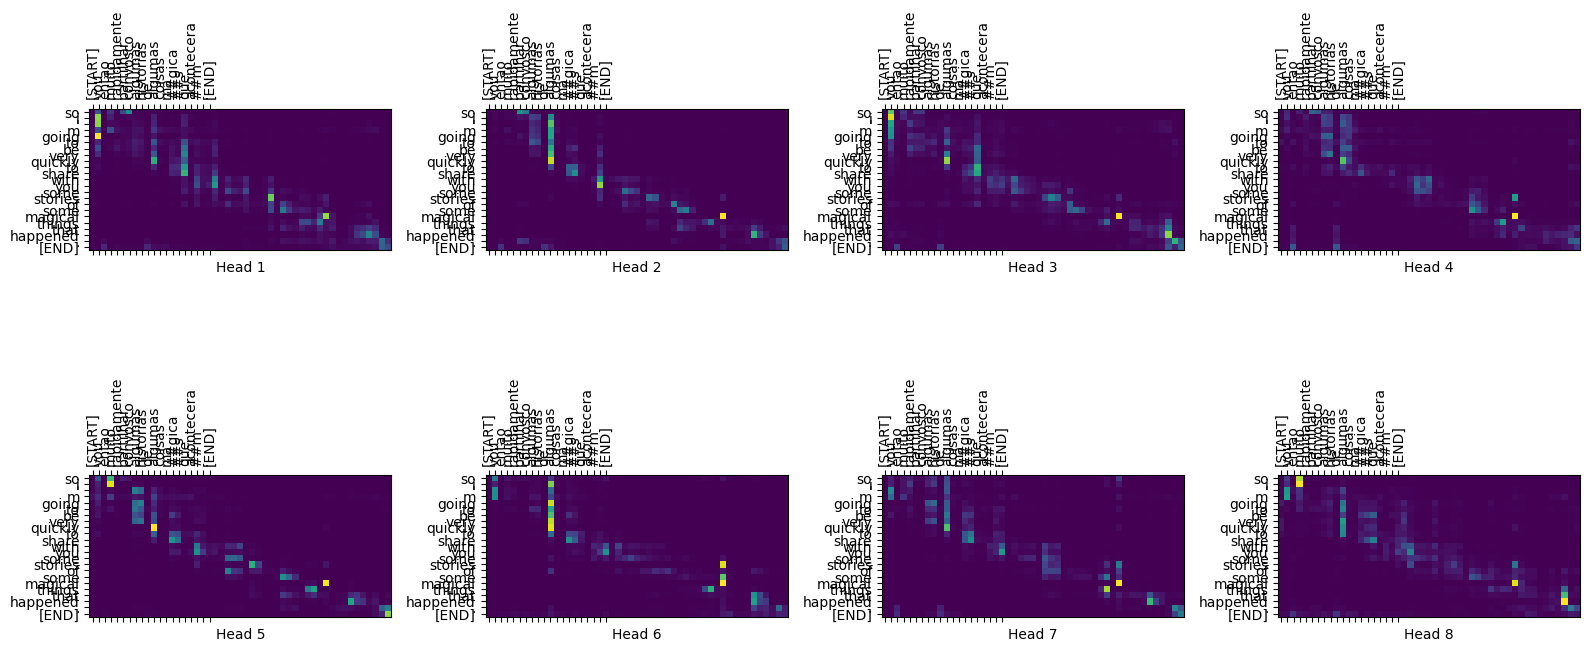

In [100]:

plot_attention_weights(sentence,
                       translated_tokens,
                       attention_weights[0])

## Export the Model

In [102]:
class ExportTranslator(tf.Module):
  def __init__(self, translator):
    self.translator = translator

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    (result,
     tokens,
     attention_weights) = self.translator(sentence, max_length=MAX_TOKENS)

    return result

In [76]:
translator = ExportTranslator(translator)

In [77]:
translator('este é o primeiro livro que eu fiz.').numpy()

2023-05-23 22:07:18.623225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'tokenized' with dtype int64 and shape [1,?]
	 [[{{node tokenized}}]]


b"` ` ` ` ' ' h12 bubble van dandrade night / night / night / night / 7 . ' '"

# Saving and Reloading

In [ ]:
tf.saved_model.save(translator, export_dir='translator')

In [103]:
reloaded = tf.saved_model.load('translator')


In [104]:

reloaded('este é o primeiro livro que eu fiz.').numpy()

2023-05-23 22:49:38.787844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor '508108' with dtype float and shape [2048,128]
	 [[{{node 508108}}]]


b'this is the first book i did .'